In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

import networkx as nx
import osmnx as ox
import folium

import osmnx as ox
import geopandas as gpd
from shapely.geometry import box, Point
import matplotlib.pyplot as plt
import numpy as np
from shapely import wkt
import os

In [21]:
import numpy as np
my_list = np.array([0,0,0,1,1,1])
min = np.min(my_list)
min_indexs = np.where(my_list == min)[0]
print(np.random.choice(min_indexs))

1


In [22]:
# Central_point = "Victory Monument,  Ratchathewi , Bangkok , Thailand"
# # Central_point  = "King Mongkut's Institute of Technology Ladkrabang, Bangkok , Thailand"
# Central_point_geocode = ox.geocode(Central_point)
# graph = ox.graph_from_point(Central_point_geocode, dist=10000, network_type='drive') # dist is redius in meters

# # city_name = "Bangkok, Thailand"
# # graph = ox.graph_from_place(city_name, network_type='drive')
# # ox.plot_graph(graph)

# nodes, edges = ox.graph_to_gdfs(graph)

# # 3) Get bounding box of nodes
# minx, miny, maxx, maxy = nodes.total_bounds

# # 4) Create 1 km x 1 km grids (approximate in degrees, or better: use projected CRS)
# # First, project to UTM (meters) for accurate 1 km grids
# nodes_utm = nodes.to_crs(nodes.estimate_utm_crs())
# minx, miny, maxx, maxy = nodes_utm.total_bounds

# grid_size = 2500 # in meters
# x_coords = np.arange(minx, maxx, grid_size)
# y_coords = np.arange(miny, maxy , grid_size)

# # 5) Create grid polygons
# polygons = []
# for x in x_coords[:-1]: #-1 means last one [start:stop(exclude):step] # i don't know why but x counts one more
#     for y in y_coords[:-1]:
#         polygons.append(box(x, y, x + grid_size, y + grid_size))

# grid = gpd.GeoDataFrame({'geometry': polygons}, crs=nodes_utm.crs)
# grid = grid.to_crs(epsg=4326) 

# # 8) Optional: plot grids + graph
# fig, ax = plt.subplots(figsize=(10,10))
# # project graph nodes to same CRS for plotting
# nodes_utm.plot(ax=ax, color='blue', markersize=1)
# grid.boundary.plot(ax=ax, edgecolor='red')
# plt.show()

In [70]:

Central_point = "Victory Monument, Ratchathewi, Bangkok, Thailand"
Central_point_geocode = ox.geocode(Central_point)

# graph = ox.graph_from_point(
#     Central_point_geocode, 
#     dist=50000, 
#     network_type='drive'
# )
bangkok_boundary = ox.geocode_to_gdf("Bangkok, Thailand")
graph = ox.graph_from_polygon(
    bangkok_boundary.geometry.iloc[0], 
    network_type="drive"
)

graph = ox.project_graph(graph)
nodes, edges = ox.graph_to_gdfs(graph)
print(nodes.crs)  

EPSG:32647


In [ ]:
# minx, miny, maxx, maxy = nodes.total_bounds

# grid_size = 2500  # meters
# x_coords = np.arange(minx, maxx, grid_size)
# y_coords = np.arange(miny, maxy, grid_size)

# polygons = []
# for x in x_coords[:-1]:
#     for y in y_coords[:-1]:
#         polygons.append(box(x, y, x + grid_size, y + grid_size))

# grid = gpd.GeoDataFrame({'geometry': polygons}, crs=nodes.crs)


# # 6) Plot (everything now uses WGS84)
# fig, ax = plt.subplots(figsize=(10, 10))
# nodes.plot(ax=ax, color='gray', markersize=0.1)
# edges.plot(ax=ax, color='gray', markersize=0.4)

# # graph.plot(ax=ax, color='gray', markersize=1)

# grid.boundary.plot(ax=ax, edgecolor='blue')
# plt.show()

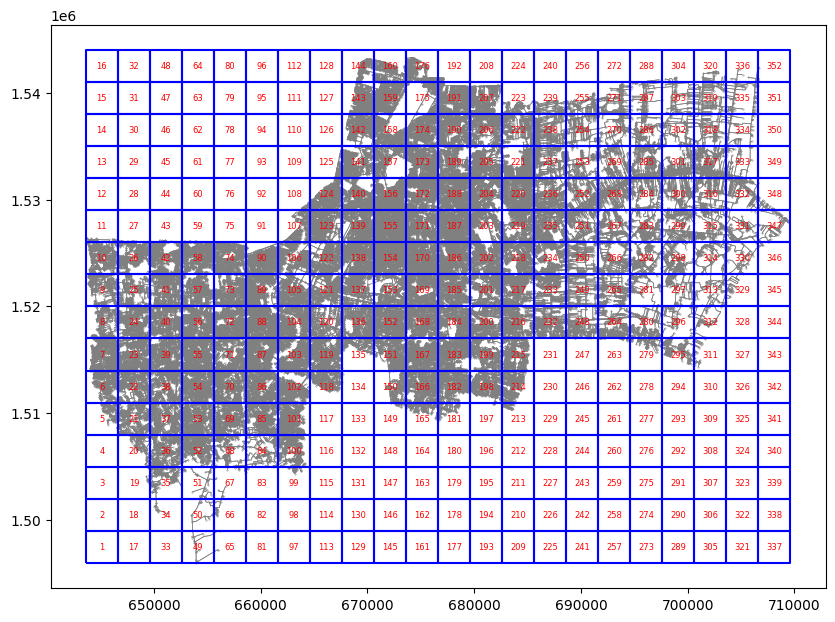

In [125]:
import matplotlib.pyplot as plt
from shapely.geometry import box

# --- your existing grid creation code ---
minx, miny, maxx, maxy = nodes.total_bounds

grid_size = 3000  # meters 5700
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

polygons = []
for x in x_coords[:]:
    for y in y_coords[:]:
        polygons.append(box(x, y, x + grid_size, y + grid_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=nodes.crs)

# --- Add IDs to each grid cell ---
grid["grid_id"] = range(1, len(grid) + 1)
grid["centroid"] = grid.geometry.centroid

# --- Plot everything ---
fig, ax = plt.subplots(figsize=(10, 10))
nodes.plot(ax=ax, color='gray', markersize=0.1)
edges.plot(ax=ax, color='gray', linewidth=0.5)
grid.boundary.plot(ax=ax, edgecolor='blue')

# Add grid numbers
for idx, row in grid.iterrows():
    x, y = row["centroid"].x, row["centroid"].y
    ax.text(x, y, str(row["grid_id"]), fontsize=6, ha="center", va="center", color="red")

plt.show()


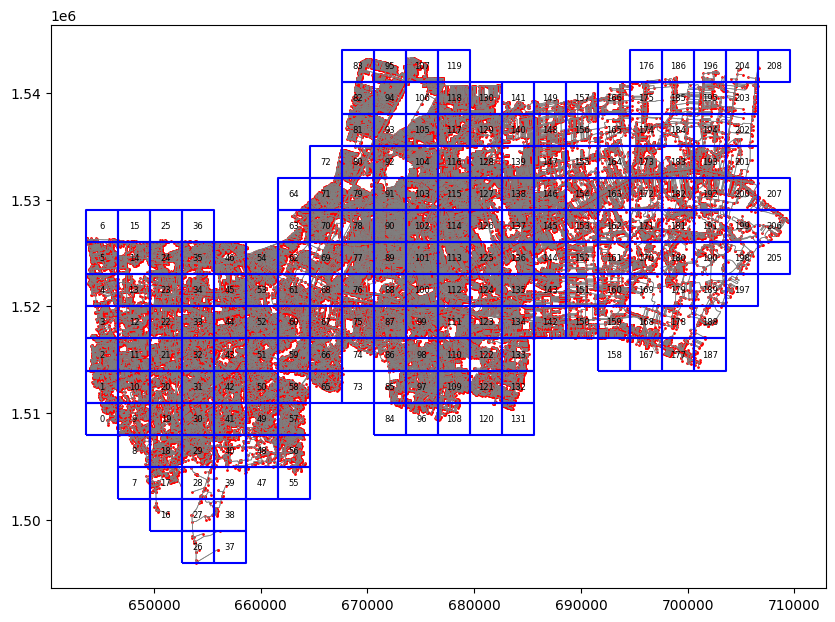

Number of grids left: 209


In [137]:
# Spatial join: assign each node to a grid cell
joined = gpd.sjoin(nodes, grid, how="left", predicate="within")

# Count nodes per grid cell
counts = joined.groupby("index_right").size()

# Keep only grid cells with >= 1 node and reset index
grid_with_nodes = grid.iloc[counts.index].copy().reset_index(drop=True)
grid_with_nodes['grid_id'] = grid_with_nodes.index
# Recompute centroids
grid_with_nodes["centroid"] = grid_with_nodes.geometry.centroid

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, color="gray", linewidth=0.5)
nodes.plot(ax=ax, color="red", markersize=1)
grid_with_nodes.boundary.plot(ax=ax, edgecolor="blue")

# Add numbers (now sequential from 0)
for idx, row in grid_with_nodes.iterrows():
    x, y = row["centroid"].x, row["centroid"].y
    ax.text(x, y, str(idx), fontsize=6, ha="center", va="center", color="black")

plt.show()

print("Number of grids left:", len(grid_with_nodes))


In [138]:
# delete edge boxes
grid_with_nodes = grid_with_nodes.drop(index=[6, 15, 25,36,64,72,119,176,186,196,204,208,207,205,197,187,158,131,120,84,73,55,47,37,38,39,16,7])

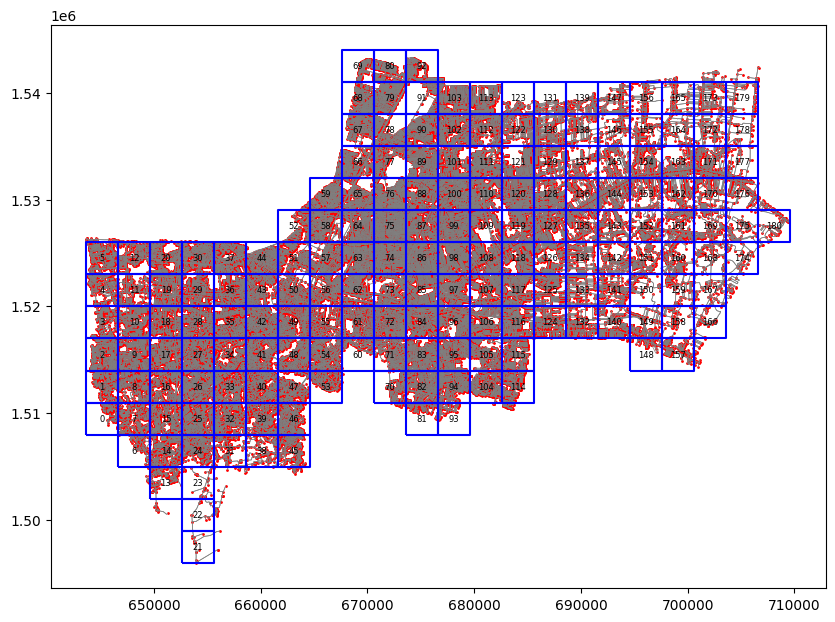

Number of grids left: 181


In [139]:
# plot new grid
grid_with_nodes = grid_with_nodes.reset_index(drop=True)
grid_with_nodes['grid_id'] = grid_with_nodes.index
# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, color="gray", linewidth=0.5)
nodes.plot(ax=ax, color="red", markersize=1)
grid_with_nodes.boundary.plot(ax=ax, edgecolor="blue")

# Add numbers (now sequential from 0)
for idx, row in grid_with_nodes.iterrows():
    x, y = row["centroid"].x, row["centroid"].y
    ax.text(x, y, str(idx), fontsize=6, ha="center", va="center", color="black")

plt.show()

print("Number of grids left:", len(grid_with_nodes))

In [140]:
grid_with_nodes

,geometry,grid_id,centroid
0,"POLYGON ((646622.224 1508001.071, 646622.224 1...",0,POINT (645122.224 1509501.071)
1,"POLYGON ((646622.224 1511001.071, 646622.224 1...",1,POINT (645122.224 1512501.071)
2,"POLYGON ((646622.224 1514001.071, 646622.224 1...",2,POINT (645122.224 1515501.071)
3,"POLYGON ((646622.224 1517001.071, 646622.224 1...",3,POINT (645122.224 1518501.071)
4,"POLYGON ((646622.224 1520001.071, 646622.224 1...",4,POINT (645122.224 1521501.071)
...,...,...,...
176,"POLYGON ((706622.224 1529001.071, 706622.224 1...",176,POINT (705122.224 1530501.071)
177,"POLYGON ((706622.224 1532001.071, 706622.224 1...",177,POINT (705122.224 1533501.071)
178,"POLYGON ((706622.224 1535001.071, 706622.224 1...",178,POINT (705122.224 1536501.071)
179,"POLYGON ((706622.224 1538001.071, 706622.224 1...",179,POINT (705122.224 1539501.071)


In [62]:
hospitals = {
    'amenity': [
        'hospital', 
        'โรงพยาบาล' 
    ],
    'healthcare': [
        'hospital',
        'โรงพยาบาล' 
    ],
    'building': [
        'hospital',
        'โรงพยาบาล'  
    ],
    'emergency': [
        'yes'  
    ]
}


potential_ambulance_bases = {
    'amenity': [
        'ambulance_station', 'fire_station', 'rescue_station',
        'สถานีรถพยาบาล', 'สถานีดับเพลิง', 'หน่วยกู้ภัย'
    ],
    'name': [
        'ambulance', 'rescue', 'emergency',
        'รถพยาบาล', 'กู้ภัย', 'ฉุกเฉิน'
    ],
    'emergency': [
        'ambulance', 'ambulance_station', 'rescue',
        'รถพยาบาล', 'กู้ภัย'
    ],
    'operator': [
        'ambulance', 'rescue', 'emergency',
        'รถพยาบาล', 'กู้ภัย', 'ฉุกเฉิน'
    ]
}

# hospitals = ox.features_from_point(Central_point_geocode, dist=10000 , tags = hospitals)


#Query hospitals inside Bangkok
hospitals = ox.features_from_polygon(
    bangkok_boundary.geometry.iloc[0],
    tags=hospitals
)

print(hospitals.head())
print("Number of hospitals:", len(hospitals))

hospitals = hospitals.to_crs(nodes.crs)

# potential_ambulance_bases = ox.features_from_point(Central_point_geocode, dist=10000 , tags = potential_ambulance_bases)
potential_ambulance_bases = ox.features_from_polygon(
    bangkok_boundary.geometry.iloc[0],
    tags=potential_ambulance_bases
)
potential_ambulance_bases = potential_ambulance_bases.to_crs(nodes.crs)
# potential_ambulance_bases = ox.features_from_place(city_name, tags = potential_ambulance_bases)


print("Potential Ambulance Bases")
print(potential_ambulance_bases.shape)  # (number_of_hospitals, number_of_attributes)
print(potential_ambulance_bases.columns.tolist())


print("Hospitals")
print(hospitals.shape)  # (number_of_hospitals, number_of_attributes)
print(potential_ambulance_bases.columns.tolist())


                                      geometry   addr:city addr:postcode  \
element id                                                                 
node    340033055   POINT (100.48012 13.75294)  บางกอกน้อย         10700   
        340033080   POINT (100.47895 13.75541)         NaN           NaN   
        1402895609   POINT (100.56167 13.8939)         NaN           NaN   
        1797189361  POINT (100.53968 13.79234)         NaN           NaN   
        1868772257  POINT (100.61817 13.90902)         NaN           NaN   

                   addr:street   amenity healthcare                  name  \
element id                                                                  
node    340033055   อิสรภาพ 44  hospital   hospital       โรงพยาบาลธนบุรี   
        340033080          NaN  hospital   hospital                   NaN   
        1402895609         NaN  hospital   hospital   โรงพยาบาลมงกุฎวัฒนะ   
        1797189361         NaN  hospital   hospital                   NaN   
     

In [63]:
# For potential ambulance bases
potential_ambulance_bases_data = potential_ambulance_bases[['name']].reset_index(drop=True)
potential_ambulance_bases_data['centroid'] = potential_ambulance_bases.geometry.centroid.values
potential_ambulance_bases_data['nearest_node_id'] = potential_ambulance_bases_data['centroid'].apply(
   lambda centroid: ox.distance.nearest_nodes(graph, centroid.x, centroid.y)
)
potential_ambulance_bases_data['geometry'] = potential_ambulance_bases_data['nearest_node_id'].apply(
    lambda node_id: Point(graph.nodes[node_id]['x'], graph.nodes[node_id]['y'])
)

# Convert to GeoDataFrame with WGS84 CRS
potential_ambulance_bases_gdf = gpd.GeoDataFrame(
    potential_ambulance_bases_data,
    geometry='geometry',
    crs=nodes.crs
)

# For hospitals
hospitals_data = hospitals[['name']].reset_index(drop=True)
hospitals_data['centroid'] = hospitals.geometry.centroid.values
hospitals_data['nearest_node_id'] = hospitals_data['centroid'].apply(
   lambda centroid: ox.distance.nearest_nodes(graph, centroid.x, centroid.y)
)
hospitals_data['geometry'] = hospitals_data['nearest_node_id'].apply(
    lambda node_id: Point(graph.nodes[node_id]['x'], graph.nodes[node_id]['y'])
)

# Convert to GeoDataFrame with WGS84 CRS
hospitals_gdf = gpd.GeoDataFrame(
    hospitals_data,
    geometry='geometry',
    crs=nodes.crs
)

In [ ]:
# # incident rate
# random_seed = 42
# rng = np.random.default_rng(seed = random_seed)
# mean_rate_0 = rng.integers(low=0, high=3, size=50)
# mean_rate_1= rng.integers(low=3, high=5, size=30)
# mean_rate_2 = rng.integers(low=5, high=7, size=10)
# mean_rate = list(mean_rate_0)+list(mean_rate_1)+list(mean_rate_2)

# minultes_per_day = 1440
# print(f"mean total incidents = {np.sum(mean_rate)}")

# grid_id = rng.choice(range(grid_with_nodes.shape[0]),size = 50)
# print(f"grid id to allocate = {grid_id}")

# grid_with_nodes['mean_rate'] = np.zeros(grid_with_nodes.shape[0])
# for id,rate in zip (grid_id,mean_rate):
#     grid_with_nodes.loc[id,'mean_rate'] = rate

# #add very high rate to incident area 24 and 53
# grid_with_nodes.loc[27,'mean_rate'] = 7
# grid_with_nodes.loc[40,'mean_rate'] = 10
# grid_with_nodes.loc[55,'mean_rate'] = 7


mean total incidents = 217
grid id to allocate = [ 78 145 152  70 162  52  43 123 115  25 150  36 145   1 144 142 141 120
  85 127  50 141 100  83  91 102   6  25  44  20  79 120 118  85 154 102
  14 138 104 114 102 100  16 101 143  55 109   5  62  79]


In [141]:
for id in range(grid_with_nodes.shape[0]):
    polygon = grid_with_nodes.iloc[id].geometry
    grid_with_nodes[f'neighbor_to_{id}'] = grid_with_nodes.geometry.touches(polygon)
grid_with_nodes


/home/thurein/ambo_allocate/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/thurein/ambo_allocate/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/thurein/ambo_allocate/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

,geometry,grid_id,centroid,neighbor_to_0,neighbor_to_1,neighbor_to_2,neighbor_to_3,neighbor_to_4,neighbor_to_5,neighbor_to_6,...,neighbor_to_171,neighbor_to_172,neighbor_to_173,neighbor_to_174,neighbor_to_175,neighbor_to_176,neighbor_to_177,neighbor_to_178,neighbor_to_179,neighbor_to_180
0,"POLYGON ((646622.224 1508001.071, 646622.224 1...",0,POINT (645122.224 1509501.071),False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,"POLYGON ((646622.224 1511001.071, 646622.224 1...",1,POINT (645122.224 1512501.071),True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"POLYGON ((646622.224 1514001.071, 646622.224 1...",2,POINT (645122.224 1515501.071),False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,"POLYGON ((646622.224 1517001.071, 646622.224 1...",3,POINT (645122.224 1518501.071),False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"POLYGON ((646622.224 1520001.071, 646622.224 1...",4,POINT (645122.224 1521501.071),False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,"POLYGON ((706622.224 1529001.071, 706622.224 1...",176,POINT (705122.224 1530501.071),False,False,False,False,False,False,False,...,True,False,False,False,True,False,True,False,False,True
177,"POLYGON ((706622.224 1532001.071, 706622.224 1...",177,POINT (705122.224 1533501.071),False,False,False,False,False,False,False,...,True,True,False,False,False,True,False,True,False,False
178,"POLYGON ((706622.224 1535001.071, 706622.224 1...",178,POINT (705122.224 1536501.071),False,False,False,False,False,False,False,...,True,True,True,False,False,False,True,False,True,False
179,"POLYGON ((706622.224 1538001.071, 706622.224 1...",179,POINT (705122.224 1539501.071),False,False,False,False,False,False,False,...,False,True,True,False,False,False,False,True,False,False


In [142]:
for id in range(grid_with_nodes.shape[0]):
    grid_with_nodes.loc[id,f'neighbor_to_{id}'] = True

In [143]:
grid_with_nodes

,geometry,grid_id,centroid,neighbor_to_0,neighbor_to_1,neighbor_to_2,neighbor_to_3,neighbor_to_4,neighbor_to_5,neighbor_to_6,...,neighbor_to_171,neighbor_to_172,neighbor_to_173,neighbor_to_174,neighbor_to_175,neighbor_to_176,neighbor_to_177,neighbor_to_178,neighbor_to_179,neighbor_to_180
0,"POLYGON ((646622.224 1508001.071, 646622.224 1...",0,POINT (645122.224 1509501.071),True,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,"POLYGON ((646622.224 1511001.071, 646622.224 1...",1,POINT (645122.224 1512501.071),True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"POLYGON ((646622.224 1514001.071, 646622.224 1...",2,POINT (645122.224 1515501.071),False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,"POLYGON ((646622.224 1517001.071, 646622.224 1...",3,POINT (645122.224 1518501.071),False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"POLYGON ((646622.224 1520001.071, 646622.224 1...",4,POINT (645122.224 1521501.071),False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,"POLYGON ((706622.224 1529001.071, 706622.224 1...",176,POINT (705122.224 1530501.071),False,False,False,False,False,False,False,...,True,False,False,False,True,True,True,False,False,True
177,"POLYGON ((706622.224 1532001.071, 706622.224 1...",177,POINT (705122.224 1533501.071),False,False,False,False,False,False,False,...,True,True,False,False,False,True,True,True,False,False
178,"POLYGON ((706622.224 1535001.071, 706622.224 1...",178,POINT (705122.224 1536501.071),False,False,False,False,False,False,False,...,True,True,True,False,False,False,True,True,True,False
179,"POLYGON ((706622.224 1538001.071, 706622.224 1...",179,POINT (705122.224 1539501.071),False,False,False,False,False,False,False,...,False,True,True,False,False,False,False,True,True,False


In [ ]:
# Create a new column to store the hospital nodes
grid_with_nodes['Neighbor_nodes'] = None
no_hospital_index = []

for i in range(grid_with_nodes.shape[0]): 
    neighbor_poly = grid_with_nodes['geometry'][grid_with_nodes[f'neighbor_to_{i}']]
    multi_poly = neighbor_poly.union_all()  
    
    # Filter hospitals within the multipolygon and get their node IDs
    hospital_nodes = hospitals_gdf[hospitals_gdf.geometry.within(multi_poly)]['nearest_node_id']
    
    # Convert to list and store in the grid DataFrame
    if not hospital_nodes.empty:
        # This should work
        grid_with_nodes.at[i, 'Neighbor_nodes'] = hospital_nodes.tolist()
    else:
    # set mean rate of no ambulances to 0
        no_hospital_index.append(i)
        grid_with_nodes.at[i, 'Neighbor_nodes'] = []  # Empty list if no hospitals
    
print(no_hospital_index)


[45, 69, 114, 129, 137, 142, 143, 144, 145, 151, 152, 153, 154, 155, 156, 159, 160, 161, 165, 167, 168, 169, 173, 174, 175, 179, 180]


In [149]:
grid_with_nodes = grid_with_nodes.drop(index=no_hospital_index)
grid_with_nodes.reset_index(drop=True, inplace=True)
grid_with_nodes['grid_id'] = grid_with_nodes.index

In [150]:
grid_with_nodes = grid_with_nodes[['geometry','Neighbor_nodes']]
grid_with_nodes

,geometry,Neighbor_nodes
0,"POLYGON ((646622.224 1508001.071, 646622.224 1...","[4525663008, 5891920613]"
1,"POLYGON ((646622.224 1511001.071, 646622.224 1...","[4525663008, 3802835463, 5891920613]"
2,"POLYGON ((646622.224 1514001.071, 646622.224 1...","[4525663008, 3802835463]"
3,"POLYGON ((646622.224 1517001.071, 646622.224 1...","[8135223600, 3802835463]"
4,"POLYGON ((646622.224 1520001.071, 646622.224 1...",[8135223600]
...,...,...
149,"POLYGON ((703622.224 1532001.071, 703622.224 1...",[1669526676]
150,"POLYGON ((703622.224 1535001.071, 703622.224 1...",[1669526676]
151,"POLYGON ((706622.224 1529001.071, 706622.224 1...",[1669526676]
152,"POLYGON ((706622.224 1532001.071, 706622.224 1...",[1669526676]


In [159]:
# incident rate
random_seed = 42
rng = np.random.default_rng(seed = random_seed)
mean_rate_0 = rng.integers(low=0, high=3, size=50)
mean_rate_1= rng.integers(low=3, high=5, size=30)
mean_rate_2 = rng.integers(low=5, high=7, size=10)
mean_rate = list(mean_rate_0)+list(mean_rate_1)+list(mean_rate_2)


minultes_per_day = 1440
print(f"mean total incidents = {np.sum(mean_rate)}")

grid_id = rng.choice(range(grid_with_nodes.shape[0]),size = 90)
print(f"grid id to allocate = {grid_id}")

grid_with_nodes['mean_rate'] = np.zeros(grid_with_nodes.shape[0])
for id,rate in zip (grid_id,mean_rate):
    grid_with_nodes.loc[id,'mean_rate'] = rate

#add very high rate to incident area 24 and 53
grid_with_nodes.loc[27,'mean_rate'] = 7
grid_with_nodes.loc[40,'mean_rate'] = 10
grid_with_nodes.loc[55,'mean_rate'] = 7


mean total incidents = 217
grid id to allocate = [ 67 123 129  59 138  44  36 105  98  21 128  30 123   1 122 121 120 102
  72 108  42 120  85  70  77  87   5  21  37  17  67 102 100  72 131  87
  12 117  88  97  87  85  13  86 122  46  92   4  53  67 151  33  42  62
 152 131   5  36 126   8 131  43 141  45  66 101  19  85  77 120 153 102
  63  62  64 125  49  25  51   3  16  13 118 111 107  71 110  24 138  77]


In [160]:
print(len(mean_rate))

90


In [152]:
row_index = 0  # Example row index
neighbor_nodes = grid_with_nodes.loc[row_index, 'Neighbor_nodes']

In [153]:
print(neighbor_nodes)

[4525663008, 5891920613]


/tmp/ipykernel_3482/1449779910.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


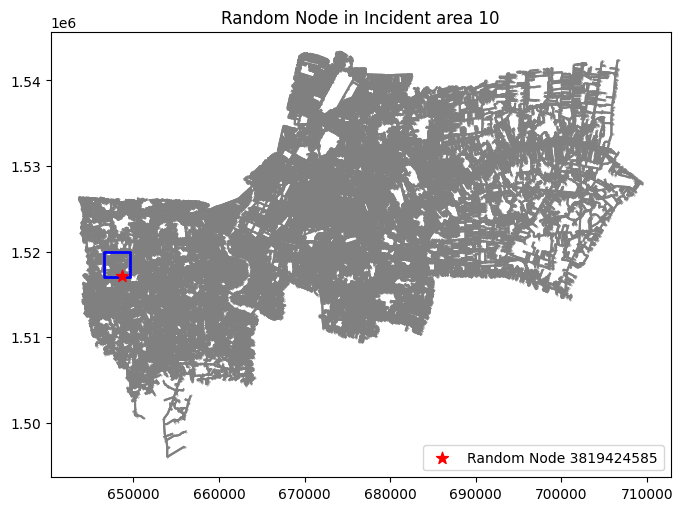

In [154]:
# Rnadom node generation
incident_area = 10
polygon = grid_with_nodes.loc[incident_area, 'geometry']
nodes_in_poly = nodes[nodes.within(polygon)]

if not nodes_in_poly.empty:
    random_node = nodes_in_poly.sample(1)
    random_node_id = random_node.index[0]

    fig, ax = plt.subplots(figsize=(8, 8))

    # 1️⃣ Plot polygon first (so it stays visible under nodes)
    gpd.GeoSeries([polygon]).plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=2,
                                  label="Polygon", zorder=3)

    # 2️⃣ Plot all nodes (but behind polygon using low zorder)
    nodes.plot(ax=ax, color="gray", markersize=0.1, alpha=1,
                zorder=1)
    edges.plot(ax=ax, color="gray", markersize=0.4, alpha=1,
                zorder=2)

    # 4️⃣ Plot random node last (on top)
    random_node.plot(ax=ax, color="red", markersize=80, marker="*",
                     label=f"Random Node {random_node_id}", zorder=4)

    ax.set_title(f"Random Node in Incident area {incident_area}")
    ax.legend()
    plt.show()


In [155]:

#testing A* Algorithm

# def Eu_distance_nodes (node1_id,node2_id):
#     node1_data = graph.nodes[node1_id]
#     node2_data = graph.nodes[node2_id]
#     coord1= (node1_data['y'],node1_data['x']) #lat/lon
#     coord2 = (node2_data['y'],node2_data['x'])

#     return geodesic(coord1, coord2).meters


def Eu_distance_nodes_1(node1_id, node2_id):
    node1_data = graph.nodes[node1_id]
    node2_data = graph.nodes[node2_id]
    dx = node2_data['x'] - node1_data['x']
    dy = node2_data['y'] - node1_data['y']
    return (dx**2 + dy**2)**0.5


polygon =  grid_with_nodes.loc[0,'geometry']
    # Filter nodes that fall inside the polygon
nodes_in_poly = nodes[nodes.within(polygon)]
# Pick a random node from those
if not nodes_in_poly.empty:
    random_node = nodes_in_poly.sample(1)   # pandas/GeoPandas sample
    random_node_id = random_node.index[0]   # graph node ID

min_distance = float('inf')

neighbor_nodes = grid_with_nodes.loc[1, 'Neighbor_nodes']
for hospital_node_id in neighbor_nodes:
            # if nx.has_path(self.graph, source=incident_node_id, target=hospital_node_id):
            #     distance = nx.shortest_path_length(self.graph, source=incident_node_id, target=hospital_node_id, weight='length')
    distance = Eu_distance_nodes_1(node1_id=random_node_id,node2_id=hospital_node_id)

    if distance < min_distance:
        min_distance = distance
        nearest_hospital_node_id = hospital_node_id

if nx.has_path(graph, source=random_node_id, target=nearest_hospital_node_id):
    actual_min_distance = nx.shortest_path_length(graph, source=random_node_id, target=nearest_hospital_node_id, weight='length')
    print("i am here")
else:
    actual_min_distance = min_distance *1.3 #use estimate if there is no actual connected nodes
print(f"a {actual_min_distance}")
# Use A* algorithm
try:
    actual_min_distance = nx.astar_path_length(
        graph, random_node_id, nearest_hospital_node_id, 
        heuristic= Eu_distance_nodes_1, weight='length'
    )
except nx.NetworkXNoPath:
    actual_min_distance = min_distance * 1.3

print(actual_min_distance)



i am here
a 6572.093069634684
6572.093069634686


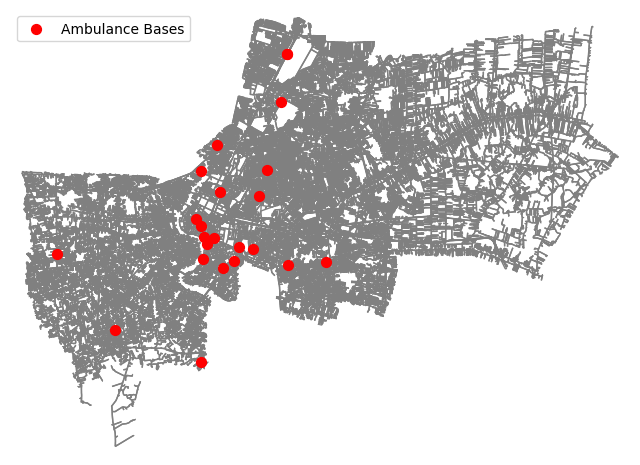

In [98]:
# Plot ambulance bases
fig, ax = ox.plot_graph(
    graph,
    show=False,
    close=False,
    bgcolor="white",     # ✅ White background
    edge_color="gray",   # ✅ Gray edges
    node_color="gray",   # ✅ Gray nodes
    node_size=0.1        # Small nodes for context
)

potential_ambulance_bases_nodes = potential_ambulance_bases_gdf['nearest_node_id'].to_list()
node_x = [graph.nodes[n]['x'] for n in potential_ambulance_bases_nodes]
node_y = [graph.nodes[n]['y'] for n in potential_ambulance_bases_nodes]

# Plot ambulance bases as red dots
ax.scatter(node_x, node_y, c="red", s=50, marker="o", label="Ambulance Bases")
plt.legend()

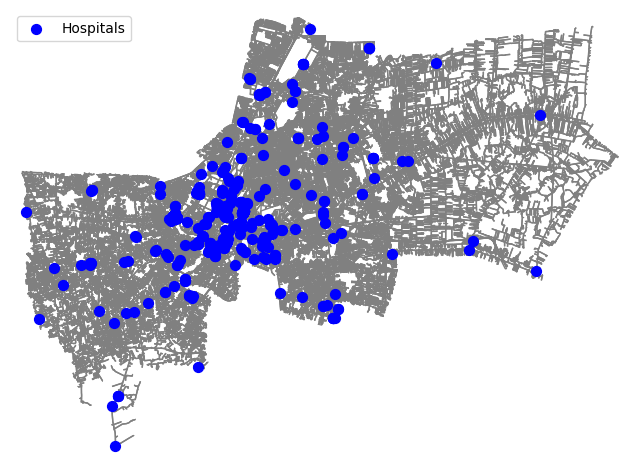

In [99]:
# Plot hospitals
fig, ax = ox.plot_graph(
    graph,
    show=False,
    close=False,
    bgcolor="white",     # ✅ White background
    edge_color="gray",   # ✅ Gray edges
    node_color="gray",   # ✅ Gray nodes
    node_size=0.1        # Small nodes for context
)

potential_ambulance_bases_nodes = hospitals_gdf['nearest_node_id'].to_list()
node_x = [graph.nodes[n]['x'] for n in potential_ambulance_bases_nodes]
node_y = [graph.nodes[n]['y'] for n in potential_ambulance_bases_nodes]

# Plot ambulance bases as red dots
ax.scatter(node_x, node_y, c="blue", s=50, marker="o", label="Hospitals")
plt.legend()

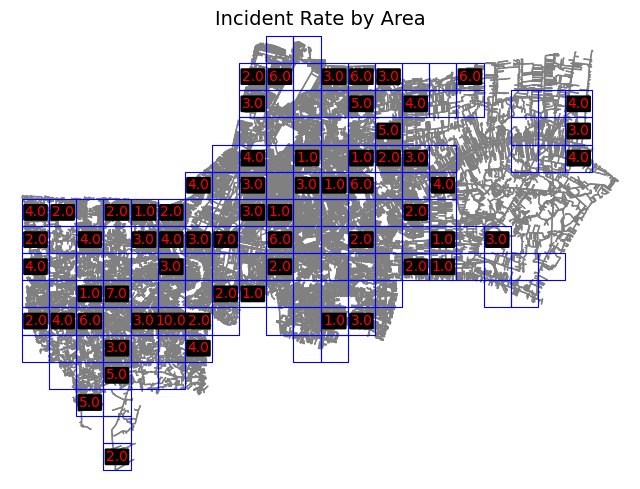

In [161]:
# Visulizing incident rates
fig, ax = ox.plot_graph(
    graph,
    show=False,
    close=False,
    bgcolor="white",     # ✅ White background
    edge_color="gray",   # ✅ Gray edges
    node_color="gray",   # ✅ Gray nodes
    node_size=0.1        # Small nodes for context
)

# Plot polygons with just borders (no color fill)
grid_with_nodes.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=0.8
)

# Add incident rate text at polygon centroids
for idx, row in grid_with_nodes.iterrows():
    centroid = row.geometry.centroid
    incident_rate = row["mean_rate"]
    if incident_rate != 0:
        ax.text(
            centroid.x,
            centroid.y,
            f"{incident_rate}",  # Display the value
            ha="center",
            va="center",
            fontsize=10,
            color="red",
            bbox=dict(facecolor="black", edgecolor="none", alpha=1, boxstyle="round,pad=0.1")
        )

plt.title("Incident Rate by Area", fontsize=14)
plt.show()


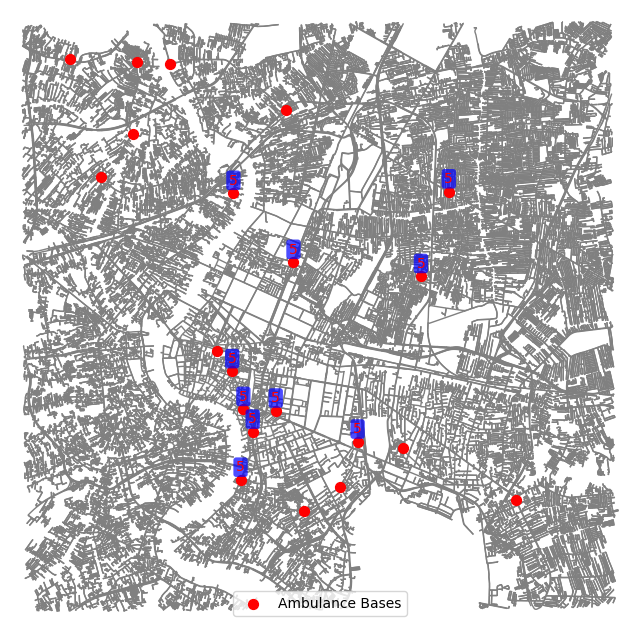

In [39]:
ambulance_allocation= {
    0: 0, 
    1: 5,
    2: 5,
    3: 0,
    4: 5,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
    10:5,
    11:5,
    12:0,
    13:0,
    14:0,
    15:5,
    16:5,
    17:5,
    18:5,
    19:0,
    20:5


}
fig, ax = ox.plot_graph(
    graph,
    show=False,
    close=False,
    bgcolor="white",     # White background
    edge_color="gray",   # Gray edges
    node_color="gray",   # Gray nodes
    node_size=0.1
)

potential_ambulance_bases_nodes = potential_ambulance_bases_gdf['nearest_node_id'].to_list()
node_x = [graph.nodes[n]['x'] for n in potential_ambulance_bases_nodes]
node_y = [graph.nodes[n]['y'] for n in potential_ambulance_bases_nodes]

# Plot ambulance bases as red dots
ax.scatter(node_x, node_y, c="red", s=50, marker="o", label="Ambulance Bases")

# Add text labels for number of ambulances at each base
for i, (x, y) in enumerate(zip(node_x, node_y)):
    count = ambulance_allocation.get(i, 0)  # Default 0 if not found
    if count > 0:  # Only show if there are ambulances
        ax.text(
            x,
            y + 200,       # small vertical offset so text is not exactly on the marker
            str(count),
            color="red",
            fontsize=10,
            ha="center",
            va="bottom",
            bbox=dict(facecolor="blue", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
        )

plt.legend()
plt.show()

In [40]:
# # First, filter the hospitals within the polygon
# # hospital_nodes_in_poly = hospitals_gdf[hospitals_gdf.geometry.within(multi_poly)]
# hospital_nodes_id_in_poly = neighbor_nodes

# # Create a plot with the graph
# fig, ax = ox.plot_graph(graph, show=False, close=False, 
#                        edge_color='gray', node_size=a0, 
#                        bgcolor='white')

# # Extract coordinates from the node geometries within the polygon
# node_x = [point.x for point in hospital_nodes_in_poly]
# node_y = [point.y for point in hospital_nodes_in_poly]

# # Plot the hospital nodes within the polygon
# ax.scatter(node_x, node_y, c='red', s=50, marker='o', 
#           label='Hospitals in Polygon', edgecolors='white', linewidth=1)

# # Optionally, plot all hospital nodes for context
# all_hospital_x = [point.x for point in hospitals_gdf.geometry]
# all_hospital_y = [point.y for point in hospitals_gdf.geometry]
# ax.scatter(all_hospital_x, all_hospital_y, c='blue', s=30, marker='o', 
#           alpha=0.3, label='All Hospitals')

# # Plot the multi_polygon boundary
# gpd.GeoSeries(multi_poly).boundary.plot(ax=ax, color='green', 
#                                        linewidth=2, label='Polygon Boundary')

# # Add legend and title
# ax.legend()
# ax.set_title('Hospital Nodes Within the Polygon')

# # Show the plot
# plt.show()

In [41]:
# # Create a plot with the graph and hospitals
# fig, ax = ox.plot_graph(graph, show=False, close=False, edge_color='gray', node_size=0)

# # Get the list of nearest node IDs
# potential_ambulance_bases_nodes = potential_ambulance_bases_data['nearest_node_id'].to_list()

# # Get node coordinates from the graph
# node_x = [graph.nodes[n]['x'] for n in potential_ambulance_bases_nodes]
# node_y = [graph.nodes[n]['y'] for n in potential_ambulance_bases_nodes]

# # Plot ambulance bases as red dots
# ax.scatter(node_x, node_y, c="red", s=50, marker="o", label="Ambulance Bases")
# plt.legend()

# # Get the list of nearest node IDs
# hospital_nodes = hospitals_data['nearest_node_id'].to_list()

# # Get node coordinates from the graph
# node_x = [graph.nodes[n]['x'] for n in hospital_nodes]
# node_y = [graph.nodes[n]['y'] for n in hospital_nodes]

# # Plot ambulance bases as red dots
# ax.scatter(node_x, node_y, c="green", s=50, marker="o", label="Hospitals")

# for polygon in grid['geometry_wgs84']:
#     # Filter nodes that fall inside the polygon
#     nodes_in_poly = nodes[nodes.within(polygon)]


#     # Pick a random node from those
#     if not nodes_in_poly.empty:
#         random_node = nodes_in_poly.sample(1)   # pandas/GeoPandas sample
#         random_node_id = random_node.index[0]   # graph node ID

#         node_x = [graph.nodes[random_node_id]['x'] ]
#         node_y = [graph.nodes[random_node_id]['y'] ]
#         ax.scatter(node_x, node_y, c="blue", s=50, marker="o", label="Incident location")


In [42]:
# nodes, edges = ox.graph_to_gdfs(graph)

# # Create a map centered at the mean of the nodes
# x_mean = nodes.x.mean()
# y_mean = nodes.y.mean()
# m = folium.Map(location=[y_mean, x_mean], zoom_start=14)

# # Add each edge as a PolyLine
# for idx, row in edges.iterrows():
#     if row['geometry'] is None:
#         continue
#     # Convert the LineString to a list of (lat, lon) pairs
#     coords = [(point[1], point[0]) for point in row['geometry'].coords]
#     folium.PolyLine(
#         locations=coords,
#         color='blue',
#         weight=2,
#         opacity=0.7,
#         popup=folium.Popup(f"Name: {row.get('name', 'N/A')}<br>Length: {row.get('length', 'N/A'):.1f}m", max_width=300)
#     ).add_to(m)

# # Add hospitals to the map
# for idx, row in potential_ambulance_bases.iterrows():
#     # Extract the name
#     name = row.get('name', 'Unknown Hospital')
    
#     # Extract the coordinates based on geometry type
#     if hasattr(row.geometry, 'centroid'):
#         # For polygons, use the centroid
#         lat, lon = row.geometry.centroid.y, row.geometry.centroid.x
#     else:
#         # For points, use the coordinates directly
#         lat, lon = row.geometry.y, row.geometry.x

#     folium.Marker(
#             location=[lat, lon],
#             tooltip=name,
#             icon=folium.Icon(color='red', icon='hospital-o', prefix='fa')
#         ).add_to(m)
# m

In [43]:
# Save graph
ox.save_graphml(graph, filepath="graph.graphml")

In [44]:
# Save grid data
import json
grid_csv = grid.copy()

grid_csv['Neighbor_nodes'] = grid_csv['Neighbor_nodes'].apply(
    lambda x: json.dumps(x) if isinstance(x, list) else json.dumps([])
)

# Convert all geometry columns to WKT
for col in grid_csv.columns:
    if hasattr(grid_csv[col], 'geom_type'):  # Check if it's a geometry column
        grid_csv[col] = grid_csv[col].apply(lambda x: x.wkt)
grid_csv.to_csv("grid_data.csv", index=False)

# Save hospitals data
hospitals_csv = hospitals_gdf.copy()
# Convert all geometry columns to WKT
for col in hospitals_csv.columns:
    if hasattr(hospitals_csv[col], 'geom_type'):  # Check if it's a geometry column
        hospitals_csv[col] = hospitals_csv[col].apply(lambda x: x.wkt)
hospitals_csv.to_csv("hospitals_data.csv", index=False)

# Save ambulance bases data
ambulance_bases_csv = potential_ambulance_bases_gdf.copy()
# Convert all geometry columns to WKT
for col in ambulance_bases_csv.columns:
    if hasattr(ambulance_bases_csv[col], 'geom_type'):  # Check if it's a geometry column
        ambulance_bases_csv[col] = ambulance_bases_csv[col].apply(lambda x: x.wkt)
ambulance_bases_csv.to_csv("ambulance_bases_data.csv", index=False)


/tmp/ipykernel_3482/3496787617.py:12: UserWarning: Geometry column does not contain geometry.
  grid_csv[col] = grid_csv[col].apply(lambda x: x.wkt)
/tmp/ipykernel_3482/3496787617.py:20: UserWarning: Geometry column does not contain geometry.
  hospitals_csv[col] = hospitals_csv[col].apply(lambda x: x.wkt)
/tmp/ipykernel_3482/3496787617.py:28: UserWarning: Geometry column does not contain geometry.
  ambulance_bases_csv[col] = ambulance_bases_csv[col].apply(lambda x: x.wkt)


In [45]:
# Define file paths
file_paths = {
    "ambulance_bases": "/home/thurein/ambo_allocate/integrate_map/ambulance_bases_data.csv",
    "grid": "/home/thurein/ambo_allocate/integrate_map/grid_data.csv",
    "graph": "/home/thurein/ambo_allocate/integrate_map/graph.graphml",
    "hospitals": "/home/thurein/ambo_allocate/integrate_map/hospitals_data.csv"
}

# Check if files exist
for name, path in file_paths.items():
    if not os.path.exists(path):
        print(f"Error: {name} file not found at {path}")
    else:
        print(f"Found {name} file at {path}")

# Load files if they exist
if all(os.path.exists(path) for path in file_paths.values()):
    ambulance_bases_csv = pd.read_csv(file_paths["ambulance_bases"])
    grid_csv = pd.read_csv(file_paths["grid"])
    graph = ox.load_graphml(file_paths["graph"])
    hospitals_csv = pd.read_csv(file_paths["hospitals"])
else:
    print("Some files are missing. Please check the paths.")

# Convert WKT back to geometry
for col in grid_csv.columns:
    if col in ['geometry']:
        grid_csv[col] = grid_csv[col].apply(wkt.loads)
# Convert back to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(grid_csv, geometry='geometry', crs="EPSG:4326")
grid_gdf['index'] = grid_gdf.index
grid_gdf['Neighbor_nodes'] = grid_gdf['Neighbor_nodes'].apply(
    lambda x: json.loads(x) if pd.notna(x) and x != '' else []
)


# Convert WKT back to geometry
for col in hospitals_csv.columns:
    if col in ['geometry']:
        hospitals_csv[col] = hospitals_csv[col].apply(wkt.loads)
# Convert back to GeoDataFrame
hospitals_gdf = gpd.GeoDataFrame(hospitals_csv, geometry='geometry', crs="EPSG:4326")
hospitals_gdf['index'] = hospitals_gdf.index

# Convert WKT back to geometry
for col in ambulance_bases_csv.columns:
    if col in ['geometry']:
        ambulance_bases_csv[col] = ambulance_bases_csv[col].apply(wkt.loads)
# Convert back to GeoDataFrame
ambulance_bases_gdf = gpd.GeoDataFrame(ambulance_bases_csv, geometry='geometry', crs="EPSG:4326")
ambulance_bases_gdf['index'] = ambulance_bases_gdf.index
print("All data loaded from CSV and converted back to GeoDataFrames")


Found ambulance_bases file at /home/thurein/ambo_allocate/integrate_map/ambulance_bases_data.csv
Found grid file at /home/thurein/ambo_allocate/integrate_map/grid_data.csv
Found graph file at /home/thurein/ambo_allocate/integrate_map/graph.graphml
Found hospitals file at /home/thurein/ambo_allocate/integrate_map/hospitals_data.csv
All data loaded from CSV and converted back to GeoDataFrames


In [46]:
# neighbor_nodes = grid_gdf.loc[0, 'Neighbor_nodes']
# for hospital_node_id in neighbor_nodes:
#     print(hospital_node_id)
    
